# Bitcoin 
## Price Prediction Model 

2021 - 
Nogues Laura 

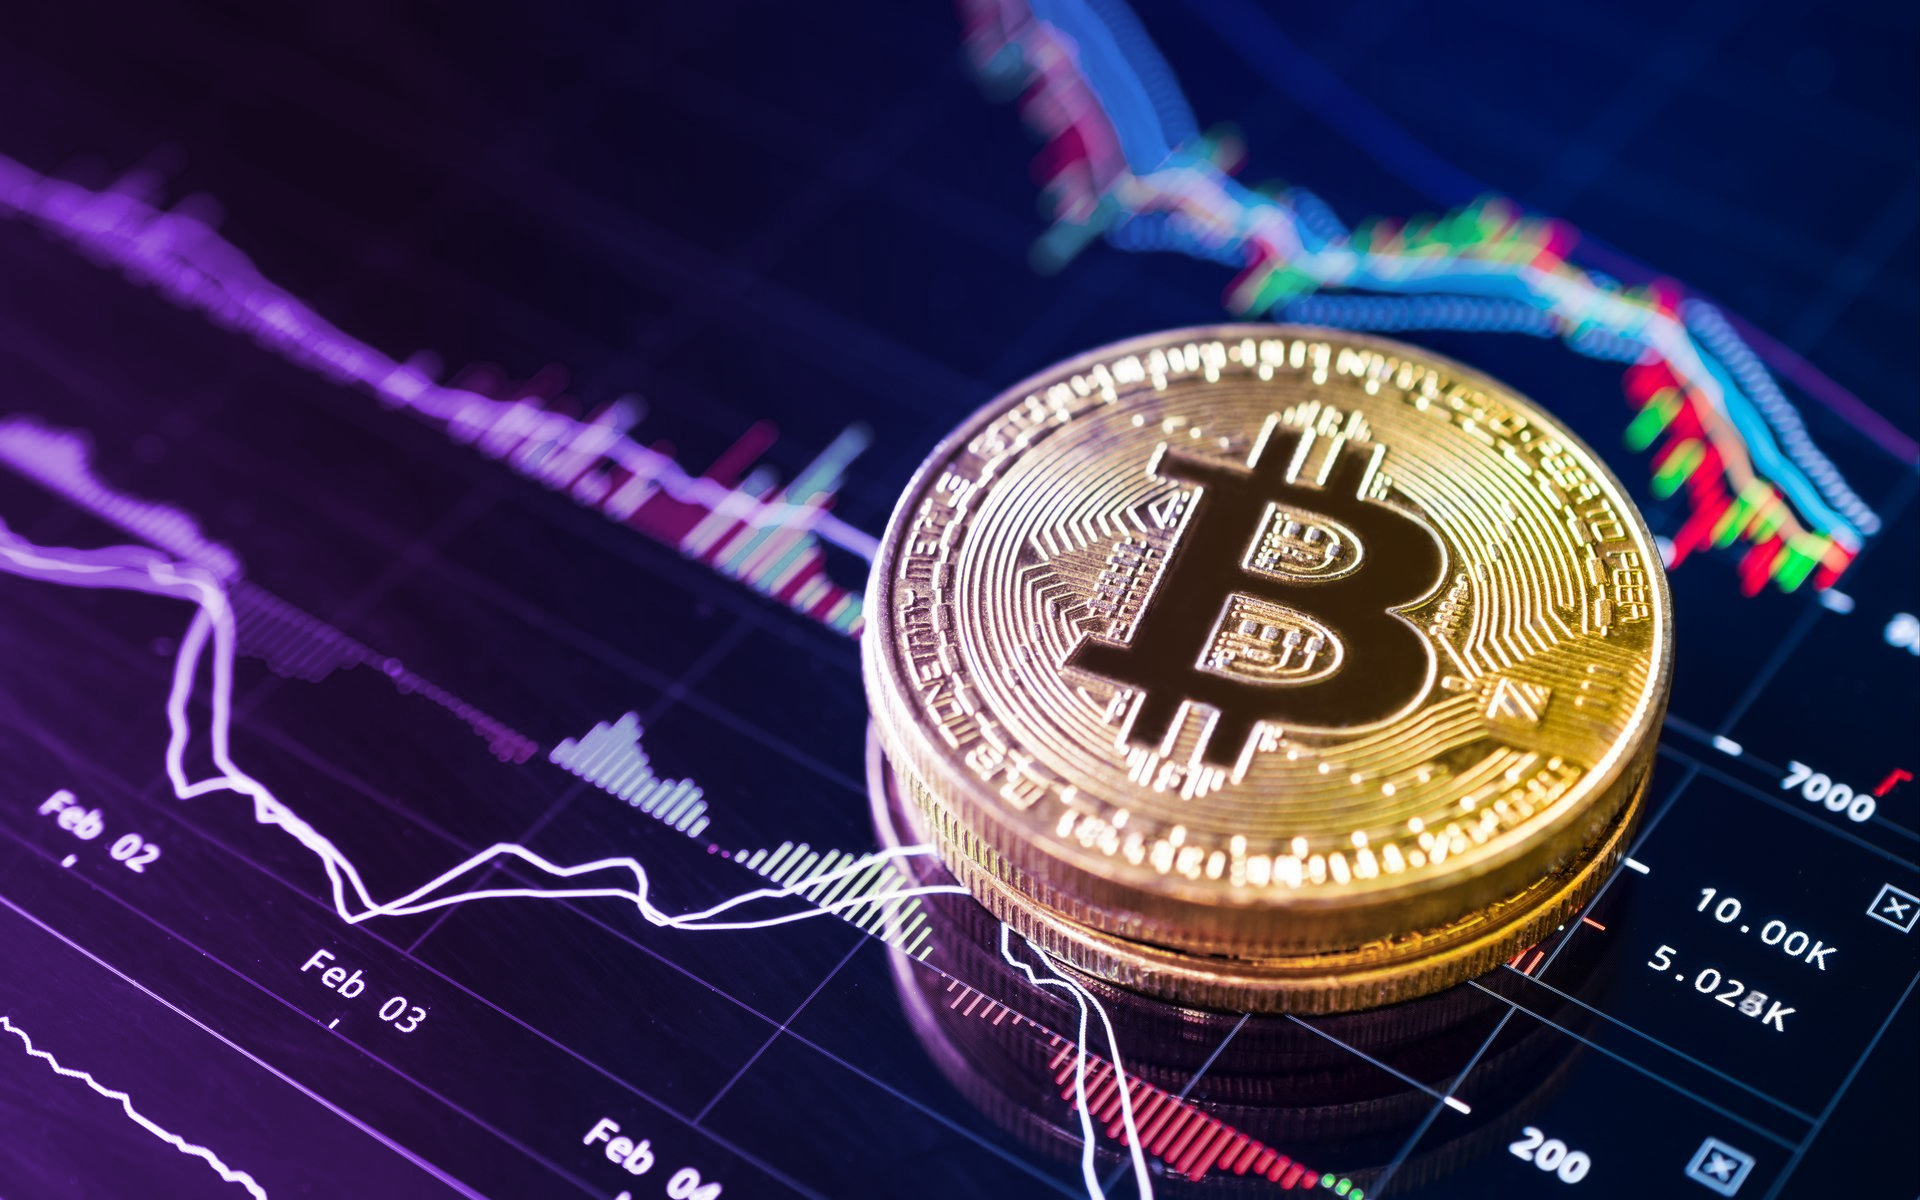

In [6]:
from IPython.display import Image
Image(filename = 'bitcoin.jpg', width = 500, height = 10)

## Content
- [Introduction](#intro)
  - [Bibliography](#biblio)
    


- [Data Preparation](#prep)
  - [Useful Functions](#func)
  - [Datasets Links](#links)
  - [API for google trends](#apigt)
  - [Data Cleaning](#clean)
- [Model I](#m1)
  - [Results](#res1)
- [Model II](#m2)
  - [Results](#res2)
  - [Model Decomposition](#desc)

<a id='intro'></a>

## Introduction

This project was originally inspired in a GitHub repository designed by proffesionals in the area. The intention was to merely reproduce the study, however we could not only replicate it but add new tools and conclusions to it. Below all the links used are available including the original project. I am not a proffesional in the field and the model does not intend to predict Bitcoin prices thus you may not rely merely in the predictions given since other variables may be considered. However, the project started as a project for a second year College course in Data Science career and ended in an extense analysis on Bitcoin. 

<a id='biblio'></a>

### Bibliography
- https://github.com/ptuls/bitcoin_price_forecasting/blob/main/Bitcoin%20Price%20Forecasting%20with%20Prophet.ipynb
- https://www.forbes.com/sites/stevenehrlich/2021/04/29/demystifying-bitcoins-remarkably-accurate-price-prediction-model-stock-to-flow/?sh=2fd1ab86476a
- https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25
- https://github.com/derkzomer/predicting-future-bitcoin-prices
- https://chart-studio.plotly.com/~BashCo/5.embed
- https://towardsdatascience.com/time-series-modeling-of-bitcoin-prices-5133edfec30b
- https://cointelegraph.com/news/how-the-most-popular-price-models-in-bitcoin-fared-in-2020
- https://towardsdatascience.com/use-python-to-send-notifications-to-your-phone-during-model-training-123a9aa257a2
- https://towardsdatascience.com/notify-with-python-41b77d51657e
- https://financialmodelingprep.com/cryptocurrency/BTCUSD 
- https://www.youtube.com/watch?v=Ru2903Srjww
- https://www.coindesk.com/price/bitcoin

<a id='prep'></a>

## Data Preparation 

In [2]:
#import libraries 
import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from fbprophet import Prophet
import plotly.express as px
import urllib
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
plt.rcParams["figure.figsize"] = (20, 10)

<a id='func'></a>

### Useful Functions 

In [3]:
def crear_dataset (url, nombre): 
    print("Start Program ... ")
    try:
        print("Start Downloading file ... ")
        url= url
        output= f'data_{nombre}.csv' 
        urllib.request.urlretrieve(url, output)
        new_name='data_{nombre}.csv'
        a= print(f'File {output} -- saved! :)' ) 
    except Exception as e:
        a= print("Downloading file error: " + str(e))
    return a 

def calculate_performance_metrics(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    rmse = mean_squared_error(y_true, y_predicted, squared=False)
    print(f"R2 score: {r2}")
    print(f"RMSE: {rmse}")
    
    
def set_nonnegative_forecasts(forecast):
    forecast.loc[forecast["yhat"] < 0, "yhat"] = 0
    forecast.loc[forecast["yhat_lower"] < 0, "yhat_lower"] = 0
    forecast.loc[forecast["yhat_upper"] < 0, "yhat_upper"] = 0    

       
def clean_google_trends_data(df, start_date, max_date):
    trends = df.copy()
    trends["Date"] = pd.to_datetime(trends["Mes"], format="%Y-%m")
    trends.drop("Mes", axis=1, inplace=True)

    # ensure maximum date matches up with price data
    trends = trends.loc[trends["Date"] >= start_date]
    trends = pd.concat(
        [trends, pd.DataFrame(data={"Date": [max_date], "Bitcoin": [np.NaN]})],
        ignore_index=True,
    )

    # perform linear interpolation
    trends = trends.set_index("Date")
    trends = trends.resample("D").mean()
    trends = trends.interpolate()
    trends = trends.reset_index()

    trends.rename(columns={"Bitcoin": "Interest"}, inplace= True)
    return trends
    

<a id='links'></a>

### Dataset Links 

As the model needs to predict on real time data, through urlib library I could extract the datasets from Yahoo Finance and quanld. From the latter you may be asked to insert the api key given once registered. Considering, you may not be interested in extracting the data on real time, all the datasets files are uploaded on GitHub and you may skip this section. 

In [15]:
#datasets links: 

#Bitcoin average block size 
BCHAIN_AVBLS= 'https://www.quandl.com/api/v3/datasets/BCHAIN/AVBLS.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_AVBLS,'avbls')

#Bitcoin difficulty
BCHAIN_DIFF= 'https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_DIFF, 'diff')

#Bitcoin hash rate 
BCHAIN_HRATE= 'https://www.quandl.com/api/v3/datasets/BCHAIN/HRATE.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_HRATE, 'hrate')

#Bitcoin number of unique bitcoin addresses used
BCHAIN_NADDU= 'https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_NADDU, 'naddu')

#Bitcoin Number of Transactions Excluding Popular Addresses
BCHAIN_NTREP= 'https://www.quandl.com/api/v3/datasets/BCHAIN/NTREP.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_NTREP, 'ntrep')

#Total Bitcoins
BCHAIN_TOTBC='https://www.quandl.com/api/v3/datasets/BCHAIN/TOTBC.csv?api_key=insertyourapikey'
crear_dataset(BCHAIN_TOTBC, 'totbc')

BTC_USD= 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1411084800&period2=1624060800&interval=1d&events=history&includeAdjustedClose=true'
crear_dataset(BTC_USD, 'btc_usd')

ETH_USD= 'https://query1.finance.yahoo.com/v7/finance/download/ETH-USD?period1=1590813428&period2=1622349428&interval=1d&events=history&includeAdjustedClose=true'
crear_dataset(ETH_USD, 'eth_usd')

#treasury bill rates 
IRX= 'https://query1.finance.yahoo.com/v7/finance/download/%5EIRX?period1=1416355200&period2=1624060800&interval=1d&events=history&includeAdjustedClose=true'
crear_dataset(IRX, 'irx')

SP500= 'https://query1.finance.yahoo.com/v7/finance/download/ES=F?period1=969235200&period2=1622332800&interval=1d&events=history&includeAdjustedClose=true'
crear_dataset(SP500, 'sp500')

Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 
Start Program ... 
Start Downloading file ... 


<a id='apigt'></a>

### API para google trends 
- https://github.com/GeneralMills/pytrends
Similarly, by using pytrends I could download Google Trends search concerning Bitcoin ensuring they were up to date. 

In [4]:
#pip install pytrends
from pytrends.request import TrendReq
import time
startTime = time.time()

pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(['Bitcoin'], 
                       timeframe='all')
btc_trends = pytrends.interest_over_time()
btc_trends.head()

,Bitcoin,isPartial
date,,
2004-01-01,0,False
2004-02-01,0,False
2004-03-01,0,False
2004-04-01,0,False
2004-05-01,0,False


In [5]:
btc_trends['Date']= btc_trends.index
btc_trends.reset_index(drop=True, inplace=True)
btc_trends["Mes"] = pd.to_datetime(btc_trends["Date"], format="%Y-%m-%d")
btc_trends.drop(['isPartial', 'Date'], axis=1, inplace= True)

In [18]:
btc_trends.tail(10)

,Bitcoin,Mes
200,12,2020-09-01
201,14,2020-10-01
202,23,2020-11-01
203,30,2020-12-01
204,62,2021-01-01
205,67,2021-02-01
206,48,2021-03-01
207,50,2021-04-01
208,64,2021-05-01
209,45,2021-06-01


<a id='clean'></a>

### Data Cleaning 

In [6]:
START_DATE = "2015-01-01"

In [10]:
btc = pd.read_csv('data_btc_usd.csv')
btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d")
btc = btc.loc[btc["Date"] >= START_DATE]

# unique addresses
addresses = pd.read_csv('data_naddu.csv')
addresses["Date"] = pd.to_datetime(addresses["Date"], format="%Y-%m-%d")
addresses = addresses.loc[addresses["Date"] >= START_DATE]
addresses = addresses.rename(columns={"Value": "addresses"})

# difficulty
difficulty = pd.read_csv('data_diff.csv')
difficulty["Date"] = pd.to_datetime(difficulty["Date"], format="%Y-%m-%d")
difficulty = difficulty.loc[difficulty["Date"] >= START_DATE]
difficulty = difficulty.rename(columns={"Value": "difficulty"})

# hashrate
hashrate = pd.read_csv('data_hrate.csv')
hashrate["Date"] = pd.to_datetime(hashrate["Date"], format="%Y-%m-%d")
hashrate = hashrate.loc[hashrate["Date"] >= START_DATE]
hashrate = hashrate.rename(columns={"Value": "hash_rate"})


# total bitcoins
total_bitcoins = pd.read_csv('data_totbc.csv')
total_bitcoins["Date"] = pd.to_datetime(total_bitcoins["Date"], format="%Y-%m-%d")
total_bitcoins = total_bitcoins.loc[total_bitcoins["Date"] >= START_DATE]
total_bitcoins = total_bitcoins.rename(columns={"Value": "total_bitcoins"})

# transactions excluding popular addresses
xpopular_addresses = pd.read_csv('data_ntrep.csv')
xpopular_addresses["Date"] = pd.to_datetime(xpopular_addresses["Date"], format="%Y-%m-%d")
xpopular_addresses = xpopular_addresses.loc[xpopular_addresses["Date"] >= START_DATE]
xpopular_addresses = xpopular_addresses.rename(columns={"Value": "transactions_excluding_popular"})

# average block size in MB
average_block_size = pd.read_csv('data_avbls.csv')
average_block_size["Date"] = pd.to_datetime(average_block_size["Date"], format="%Y-%m-%d")
average_block_size = average_block_size.loc[average_block_size["Date"] >= START_DATE]
average_block_size = average_block_size.rename(columns={"Value": "average_block_size_mb"})

# Google Trends worldwide sentiment about Bitcoin (Topic)
google_trends_sentiment = clean_google_trends_data(btc_trends, START_DATE, btc["Date"].max())

In [11]:
from functools import reduce
additional_regressors = [
    addresses,
    difficulty,
    hashrate,
    total_bitcoins,
    xpopular_addresses,
    average_block_size,
    google_trends_sentiment,
]

In [12]:
btc_features = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), additional_regressors)
btc_features[['Date', 'Open']] = btc[["Date", "Open"]]
btc_features.dropna(inplace=True)
btc_features.columns

Index(['Date', 'addresses', 'difficulty', 'hash_rate', 'total_bitcoins',
       'transactions_excluding_popular', 'average_block_size_mb', 'Interest',
       'Open'],
      dtype='object')

In [13]:
btc_features.describe()

,addresses,difficulty,hash_rate,total_bitcoins,transactions_excluding_popular,average_block_size_mb,Interest,Open
count,2.256000e+03,2.256000e+03,2.256000e+03,2.256000e+03,2256.000000,2256.000000,2256.000000,2256.000000
mean,4.840785e+05,5.755214e+12,4.194470e+07,1.668638e+07,243969.619238,0.905888,15.208666,6220.856527
std,1.553524e+05,6.647115e+12,4.834065e+07,1.395177e+06,75778.620957,0.269696,16.277516,7896.851726
min,1.615000e+05,4.064096e+10,2.295135e+05,1.367248e+07,66773.000000,0.187484,2.000000,176.897003
25%,3.906168e+05,2.133989e+11,1.536420e+06,1.577244e+07,194372.750000,0.739206,3.580645,600.252762
50%,4.806960e+05,2.605474e+12,2.070681e+07,1.684859e+07,251528.000000,0.948326,12.409677,4374.324952
75%,5.745525e+05,1.018349e+13,7.746856e+07,1.789232e+07,305229.750000,1.092174,17.169355,8915.888916
max,1.072861e+06,2.172413e+13,1.749392e+08,1.864931e+07,470650.000000,1.445759,100.000000,57532.738281


In [14]:
btc_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256 entries, 104 to 2363
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            2256 non-null   datetime64[ns]
 1   addresses                       2256 non-null   float64       
 2   difficulty                      2256 non-null   float64       
 3   hash_rate                       2256 non-null   float64       
 4   total_bitcoins                  2256 non-null   float64       
 5   transactions_excluding_popular  2256 non-null   float64       
 6   average_block_size_mb           2256 non-null   float64       
 7   Interest                        2256 non-null   float64       
 8   Open                            2256 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 176.2 KB


<a id='m1'></a>

## Model I
- The first Model shows the prices behaviour using Phrophet algorithm without considering the additional features. The idea is to compare model 1 and model 2, since one will predict using the open and close prices tendencies and the second will include more regressors making the predictions more precise. 

In [15]:
PREDICTION_CUTOFF = "2021-01-01"

In [16]:
input_df = btc_features[
    [
        "Date", 
        "Open", 
    ]
]
# column name remapping for Prophet
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [17]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188 entries, 104 to 2295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2188 non-null   datetime64[ns]
 1   y       2188 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.3 KB


In [18]:
input_df.head()

,ds,y
104,2015-01-01,320.434998
105,2015-01-02,314.079010
106,2015-01-03,314.846008
107,2015-01-04,281.145996
108,2015-01-05,265.084015


In [19]:
init_model = Prophet(
    daily_seasonality=False, 
    seasonality_mode="multiplicative"
)
init_model.fit(input_df);

In [20]:
train_forecast = init_model.predict(input_df)

In [21]:
# set all non-negative early price forecasts to 0
set_nonnegative_forecasts(train_forecast)

<a id='res1'></a>

### Results 

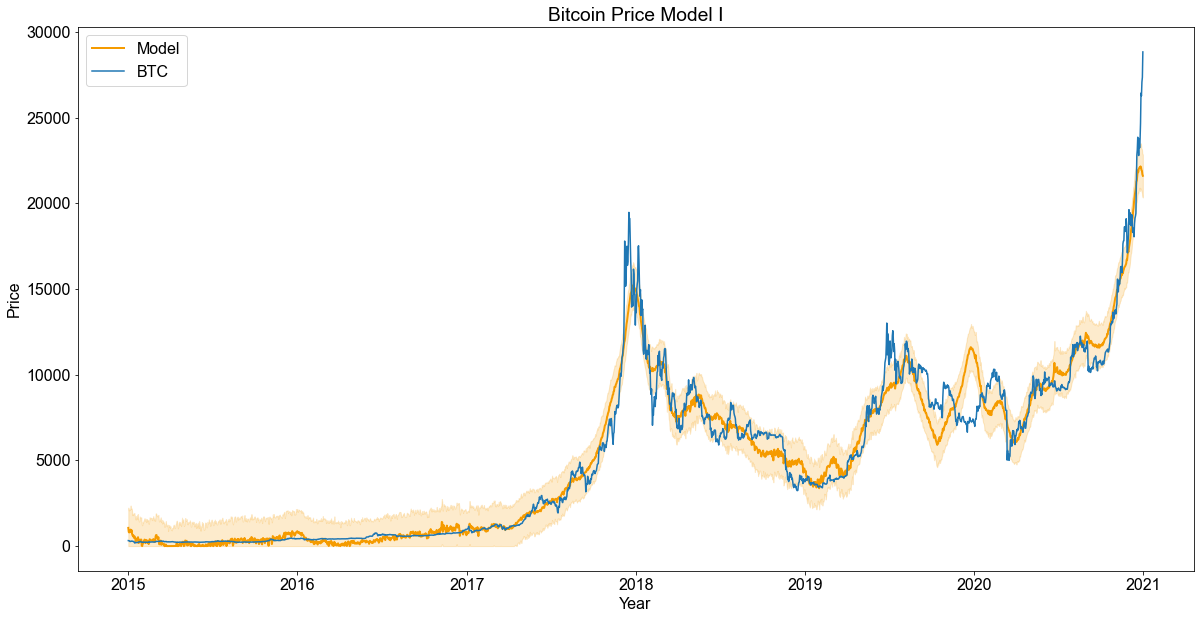

In [46]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="Model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("Price");
plt.title("Bitcoin Price Model I");
plt.legend();

In [41]:
# This plotly express is not compatible with GitHub but the code is useful in case you may want to reproduce the interactive graph as they are very useful in analysing price predictions. 
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_forecast["ds"], y=train_forecast["yhat"],
                    mode='lines',
                    name='Model'))
fig.add_trace(go.Scatter(x= train_forecast["ds"], y=input_df["y"],
                    mode='lines',
                    name='BTC'))
fig.update_layout(title='Bitcoin Price Prediction Model I',
                   xaxis_title='Date',
                   yaxis_title='Price')

In [27]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
R2 score: 0.953810616230629
RMSE: 1003.5549363723609


### Test Set 

In [28]:
forecast_init = init_model.predict(future_df)
forecast_init[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
53,2021-02-23,15094.796187,13594.576217,16534.648491
54,2021-02-24,15057.933131,13584.837387,16380.675745
55,2021-02-25,15101.123322,13630.332211,16594.264493
56,2021-02-26,14959.826150,13563.737964,16428.181475
57,2021-02-27,14937.323577,13457.907141,16352.589063
58,2021-02-28,14950.251181,13512.007464,16317.857526
59,2021-03-01,14815.131913,13429.064952,16312.064867
60,2021-03-02,14803.334213,13355.942713,16246.803849
61,2021-03-03,14643.747012,13234.765470,16134.979125
62,2021-03-04,14563.645001,13185.269179,16027.763332


In [30]:
print("Metrics on test set")
calculate_performance_metrics(forecast_init.loc[:, "yhat"], future_df["y"])

Metrics on test set
R2 score: -163.55871923030423
RMSE: 27035.714271536235


In [31]:
calculate_performance_metrics(forecast_init.loc[:, "yhat_upper"], future_df["y"])

R2 score: -153.19816110904887
RMSE: 25746.401863848558


<a id='m2'></a>

# Model II 
For the second model additional factors affecting Bitcoin Prices were considered. So we can improve our estimates by factoring in additional information i.e., additional regressors. The additional factors are: 

- the number of unique addresses
- the difficulty of mining as time progresses
- the hash rate
- the total number of bitcoins in circulation
- the number of transactions excluding popular addresses
- the average block size in MB
- search trend sentiment from Google Trends

In [32]:
input_df = btc_features[
   ['Date', 'addresses', 'difficulty', 'hash_rate', 'total_bitcoins',
       'transactions_excluding_popular', 'average_block_size_mb', 'Interest',
       'Open']
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
    "addresses": "addresses",
    "difficulty": "difficulty",
    "hash_Rate": "hash_rate",
    "total_Bitcoins": "total_bitcoins",
    "transactions_excluding_popular": "transactions_excluding_popular",
    "average_block_size_mb": "average_block_size_mb",
    "Interest": "interest",
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [33]:
extended_model = Prophet(
    daily_seasonality=False, 
    seasonality_mode="multiplicative"
)

for col in input_df.columns:
    if col not in ["ds", "y"]:
        extended_model.add_regressor(col, mode="additive")

extended_model.fit(input_df);

In [34]:
train_forecast = extended_model.predict(input_df)

In [35]:
# set all non-negative early price forecasts to 0
set_nonnegative_forecasts(train_forecast)

<a id='res2'></a>

## Results

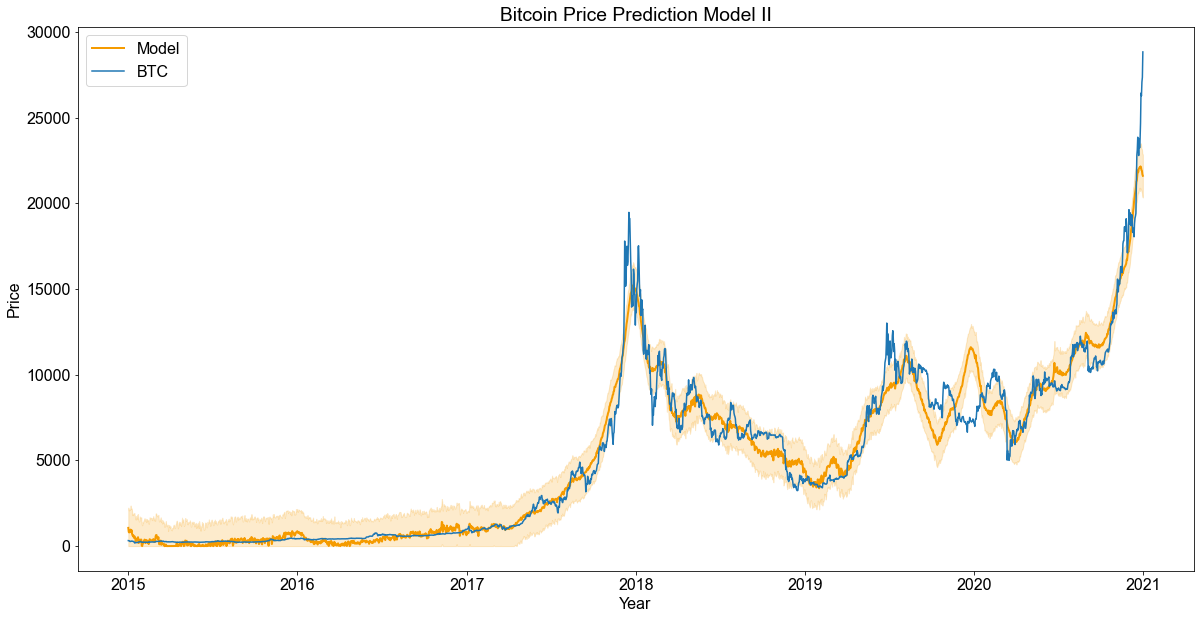

In [45]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="Model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("Price");
plt.title("Bitcoin Price Prediction Model II");
plt.legend();

In [40]:
# Again this code may not run on GitHub but it is included in case you are interested in reproducing it. 
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_forecast["ds"], y=train_forecast["yhat"],
                    mode='lines',
                    name='Model'))
fig.add_trace(go.Scatter(x= train_forecast["ds"], y=input_df["y"],
                    mode='lines',
                    name='BTC'))
fig.update_layout(title='Bitcoin Price Prediction Model II',
                   xaxis_title='Date',
                   yaxis_title='Price')

This model adapts itself better to the price fluctuations, we may also consider Bitcoin's sensibility to diverse variables as a factor that generates once in a while a huge gap between predictions and real prices. However, comparing both models we may observe that the uncertainty around the forecast is reduced greatly. 

In [47]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
R2 score: 0.9543628011328085
RMSE: 997.3767384830429


In [48]:
forecast = extended_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
53,2021-02-23,14932.473735,13599.439017,16372.504832
54,2021-02-24,14892.518770,13389.977953,16281.010601
55,2021-02-25,14869.496599,13451.323568,16306.720287
56,2021-02-26,14770.769583,13464.619599,16212.149266
57,2021-02-27,14942.289559,13606.856957,16478.215167
58,2021-02-28,14874.334263,13441.692199,16303.074475
59,2021-03-01,14689.905446,13248.475807,16207.310068
60,2021-03-02,14649.655844,13226.635068,16111.168179
61,2021-03-03,14389.068299,12809.496668,15756.201200
62,2021-03-04,14304.232886,12843.389585,15847.423128


In [49]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
R2 score: -150.26885461410026
RMSE: 27147.724090410036


<a id='desc'></a>

### Model Decomposition 

Prophet can decompose the underlying trends of the price as a function of time. This splits the forecasts into 3 components

- trend
- weekly
- yearly

C:\Users\tatin\anaconda3\anaconda\envs\my-proj\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\tatin\anaconda3\anaconda\envs\my-proj\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



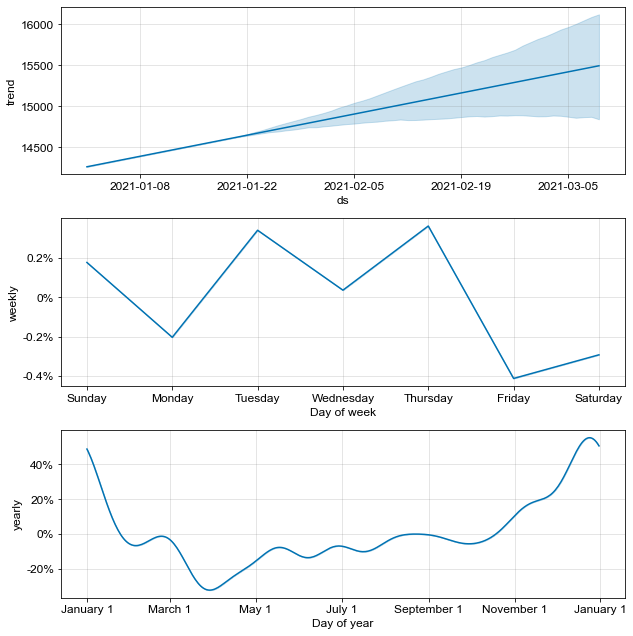

In [49]:
plt.rc("font", family="arial", size=12)
fig = init_model.plot_components(forecast_init)

C:\Users\tatin\anaconda3\anaconda\envs\my-proj\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\tatin\anaconda3\anaconda\envs\my-proj\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\tatin\anaconda3\anaconda\envs\my-proj\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



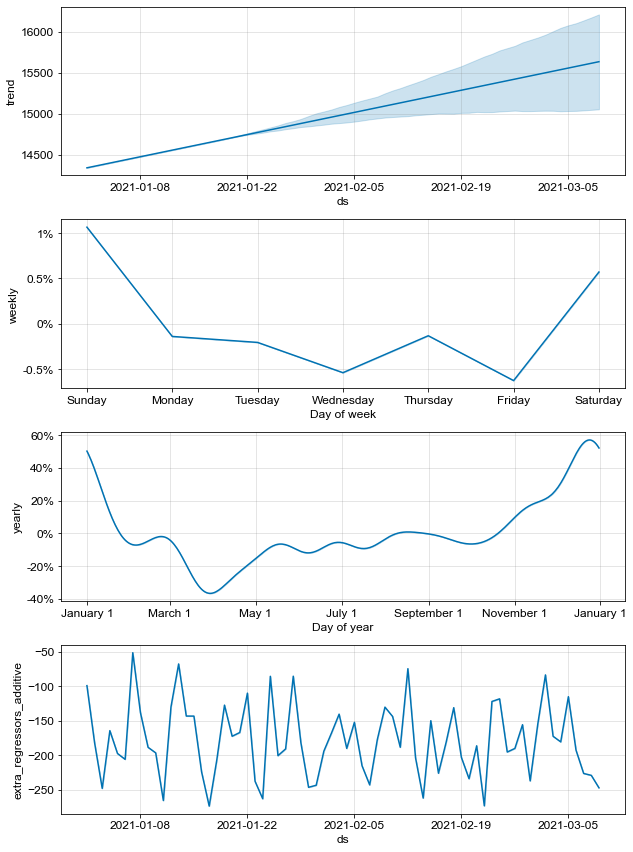

In [50]:
plt.rc("font", family="arial", size=12)
fig = extended_model.plot_components(forecast)

Prophet algorithm allows us to decompose the model to observe the underlying trends behind its predictions. For example, it is evident that the google search tendencies have been increasing during the last months, besides on tuesdays and thursdays the price tends to be higher, and the prices tend to ascend during the end of the year so they can go down again in March. 